In [1]:
import matplotlib.pyplot as plt
from scipy.signal import lti
import numpy as np
from numpy import pi, sin, cos
from scipy.integrate import odeint
import control

In [2]:
def Plot_state(x,dx,th,dth,t):
    fig, axs = plt.subplots(2, 2, figsize = (12,10))
    axs[0,0].plot(t, x)
    axs[0,0].set_xlabel('time')
    axs[0,0].set_ylabel('position')
    axs[0,0].set_title("Position of Cart")
    axs[0,0].grid(True)

    axs[0,1].plot(t, dx)
    axs[0,1].set_xlabel('time')
    axs[0,1].set_ylabel('velocity')
    axs[0,1].set_title("Velocity Cart")
    axs[0,1].grid(True)

    axs[1,0].plot(t, th)
    axs[1,0].set_xlabel('time')
    axs[1,0].set_ylabel('angle')
    axs[1,0].set_title("Angle of Pendulum")
    axs[1,0].grid(True)

    axs[1,1].plot(t, dth)
    axs[1,1].set_xlabel('time')
    axs[1,1].set_ylabel('omega')
    axs[1,1].set_title("Omega of Pendulum")
    axs[1,1].grid(True)

<h3> Non linear modelling of Inverted Pendulum

In [4]:
# physical constants
M = 0.5;
m = 0.2;
b = 0.2;
I = 0.0034;
g = 9.8;
l = 0.3;

#motor parameter
k = 0.5 # motor torque constant
R = 6.5 # motor resistance
r = 0.05   # shaft radius
J = 0.0001
L = 0.1*10**(-6)

In [5]:
def Force_input(t):
    if t < 0.0001:
        F = 1
    else:
        F = 0
    return F

In [6]:
#from ctms engin umic edu
class Pendulum_Non_Linear:
    def __init__(self):
        self.state = np.array([0,0,pi + pi/20,0])
        self.change_state(self.state)
        self.change_input(0)

    def change_input(self,x):
        self.V = x

    def change_state(self,x):
        self.x = x[0]
        self.dx = x[1]
        self.th = x[2]
        self.dth = x[3]
        self.output = [self.x,self.dx, self.th,self.dth]
        self.state = np.array([self.x, self.dx, self.th, self.dth])
    
    def derivative(self,F):
        self.change_input(F)
        x_dot = self.dx 
        D = (M+m)*(I+m*l*l) - (m*l*cos(self.th))**2
        dx_dot = ((I+m*l*l)*(F + m*l*self.dth*self.dth*sin(self.th)-b*self.dx) + (m*g*l*sin(self.th))*(m*l*cos(self.th)))/D
        th_dot = self.dth
        dth_dot = (-(M+m)*(m*g*l*sin(self.th))- m*l*cos(self.th)*(F + m*l*self.dth*self.dth*sin(self.th) - b*self.dx))/D
        return np.array([x_dot,dx_dot,th_dot,dth_dot])

In [7]:
#testing nonlinear pendulum model
def control_simulation_non_linear_pendulum(pendulum):
    position = []
    velocity = []
    theta = []
    omega = []
    for t in ts:
        F = Force_input(t)
        pendulum.change_state(pendulum.state + pendulum.derivative(F)*dt)
    
        position.append(pendulum.output[0])
        velocity.append(pendulum.output[1])
        theta.append(pendulum.output[2])
        omega.append(pendulum.output[3])
        
    return np.array([position, velocity,theta,omega])

In [8]:
ts = np.arange(0, 100, 10**(-4))
dt = ts[1]

pendulum = Pendulum_Non_Linear()
x,dx,th,dth = control_simulation_non_linear_pendulum(pendulum)

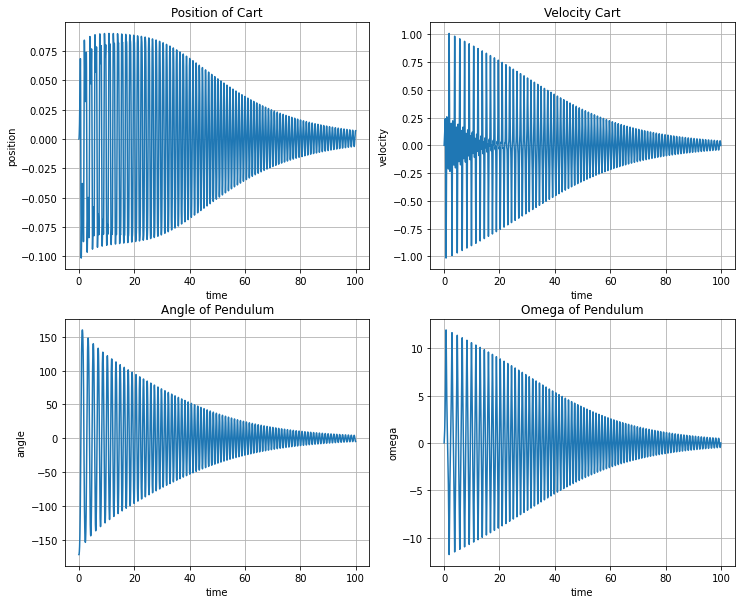

In [9]:
Plot_state(x,dx,(th*180/pi)-360,dth,ts)

<h3> Linearization of non linear pendulum model </h3>
    Linearization has been performed about angle $\pi$. The angle for vertical is 0.

In [10]:
p = I*(M+m)+M*m*l**2;


A = np.array([[0   ,   1    ,          0   ,        0],
              [0 , -(I+m*l**2)*b/p , (m**2*g*l**2)/p ,  0],
              [0 ,     0         ,     0    ,       1],
              [0 , -(m*l*b)/p   ,    m*g*l*(M+m)/p , 0]])

B = np.array([[0],
          [(I+m*l**2)/p],
          [0],
          [m*l/p]])
C = np.array([[1 ,0 ,0 ,0],
              [0 ,1 ,0 ,0],
              [0 ,0 ,1 ,0],
              [0 ,0 ,0 ,1]])
D = np.array([[0],
     [0],
     [0],
     [0]])

In [11]:
class Pendulum_Linear:
    def __init__(self, A,B,C,D, x0=None):
        self.Gss = control.ss(A,B,C,D)
        self.state = x0
        self.state = np.zeros((self.Gss.A.shape[0], 1)) if x0 is None else x0
        self.change_state(self.state)
        
    def change_input(self,F):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(F)
        self.output = np.array([self.y[0, 0],self.y[1,0],self.y[2,0], self.y[3,0]]) 

    def change_state(self,x):
        self.x = self.state = x
    
    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)

In [12]:
#testing linear model of pendulum
def control_simulation_linear_pendulum(pendulum):
    position = []
    velocity = []
    theta = []
    omega = []
    for t in ts:
        F = Force_input(t)
        pendulum.change_state(pendulum.state + pendulum.derivative(F)*dt)
    
        position.append(pendulum.output[0])
        velocity.append(pendulum.output[1])
        theta.append(pendulum.output[2])
        omega.append(pendulum.output[3])
        
    return np.array([position, velocity,theta,omega])

In [13]:
ts = np.arange(0, 2, 10**(-4))
dt = ts[1]
x0 = np.array([[0],[0],[0],[0]])

pendulum = Pendulum_Linear(A,B,C,D,x0)
x,dx,th,dth=control_simulation_linear_pendulum(pendulum)

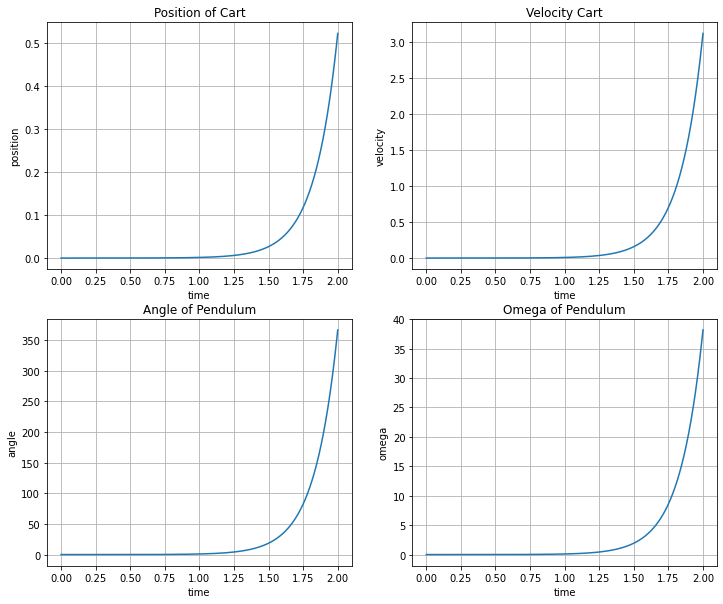

In [14]:
Plot_state(x,dx,th*180/pi,dth,ts)

In [15]:
#modelling of dc motor, V as input and F as output
class Motor:
    def __init__(self, J,b,R,L,k,r):
        self.J = J
        self.b = b 
        self.R = R
        self.L = L
        self.k = k
        self.r = r
        self.Gss = self.get_Gss()
        self.state = np.array([[0],[0],[0]])
        self.change_state(self.state)
        

    def change_input(self,V):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(V)
        self.output = self.y[0,0]

    def change_state(self,x):
        self.x = self.state = x

    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)
    
    def get_Gss(self):
        A = np.array([[0,1,0],
                        [0,-self.b/self.J,self.k/self.J],
                        [0, -self.k/self.L, -self.R/self.L]])
        B = np.array([[0],[0],[1/self.L]])
        C = np.array([[0,(-self.k*self.k/(self.R*self.r)),0]])
        D = np.array([[self.k/(self.R*self.r)]])
        return control.ss(A,B,C,D)

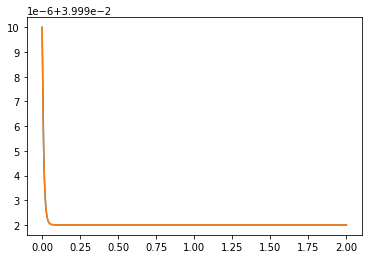

In [16]:
#test motor model
motor = Motor(J=0.001,b=0.1,R=5,L=0.005,k=0.01,r=0.05)
sys = motor.Gss
T, yout = control.step_response(sys, ts, X0 = 0) # for step input in voltage

#or you can test it like this
motor = Motor(J=0.001,b=0.1,R=5,L=0.005,k=0.01,r=0.05)
out =[]
for t in ts:
    motor.change_state(motor.state + motor.derivative(1.0)*dt)
    out.append(motor.output)
plt.plot(T,yout)
plt.plot(ts,out)

In [17]:
#modelling of angle sensor as first order model
class angle_sensor:
    def __init__(self,K, T):
        self.G = lti([K], [T,1])
        self.Gss = self.G.to_ss()
        self.state = np.array([[0]])
        self.change_state(self.state)

    def change_input(self,u):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(u)
        self.output = np.array([self.y[0,0]])

    def change_state(self,x):
        self.x = self.state = x

    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)

In [18]:
#unifying both motor and pendulum model
pendulum = Pendulum_Linear(A,B,C,D)
motor = Motor(J=0.001,b=0.1,R=5,L=0.005,k=0.01,r=0.05)
motor_pendulum = control.series(motor.Gss,pendulum.Gss)

In [19]:
T, yout = control.step_response(motor_pendulum, ts, X0 = 0) # for step input in voltage
x,dx,th,dth = yout

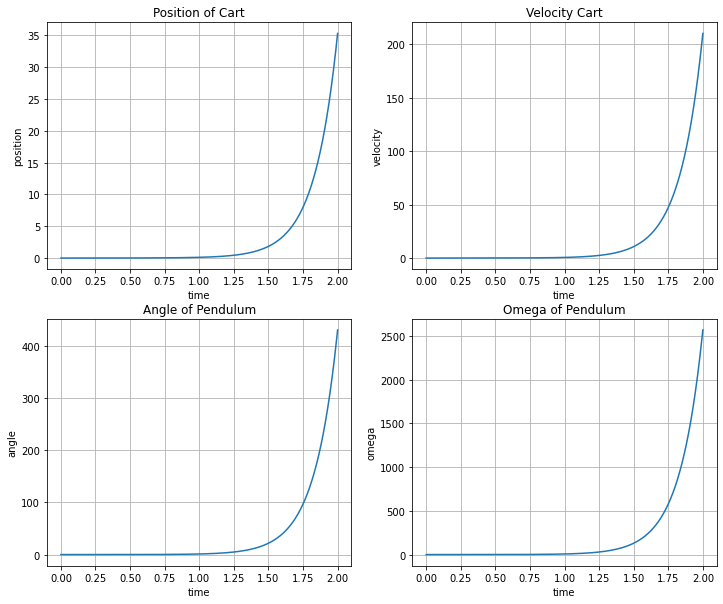

In [20]:
Plot_state(x[0],dx[0],th[0],dth[0],ts)